In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
def factorial(n):
    if not n: return 1
    fact = 1
    for i in range(1, n+1):
        fact *= i
    return fact

In [3]:
year = []
population = []

with open("population-by-age-group-with-projections.csv") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    
    for line in csv_reader:
        if line["Entity"] == "India" and int(line["Year"]) < 2022:
            year.append(int(line["Year"]))
            population.append(int(line["Population - Sex: all - Age: all - Variant: estimates"])//1e6)
            
# print(year)
# print(population)

In [4]:
def multiply(a, d, deg, size):
    if not deg: return np.array([0 for i in range(1, size)]+[1], dtype="float64")
    elif deg == 1: return 1/d * np.array([0 for i in range(2, size)] + [1, a], dtype="float64")
    else:
        arr = np.array([1, a], dtype="float64")
        for i in range(1, deg):
            a = a - d
            temp = arr * a
            arr = np.append(arr, [0])
            temp = np.append([0], temp)
            arr = arr + temp
        
        arr = 1/d**deg * np.append([0 for i in range(deg+1, size)], arr)
        return arr

In [5]:
def difference_table(y):
    iterate = len(y)-1
    
    diff_table = [y]
    for i in range(iterate):
        diff = []
        for j in range(len(y)-1):
            diff.append(y[j+1]-y[j])
        diff_table.append(diff)
        y = diff
        
    dells = np.array([diff_table[i][0] for i in range(iterate+1)], dtype="float64")
    return dells

In [6]:
def interpolation(dells): 
    constants = np.zeros(len(dells))
    for i, dell in enumerate(dells):
        constants = constants + dell*multiply(-1, 1, i, len(dells))/factorial(i)
    return constants

In [7]:
def execute(x, constants):
    result = 0
    for i, value in enumerate(constants):
        result += value*x**(len(constants)-i-1)
    return result

In [8]:
def differentiation(constants):
    derivatives = []

    for i, value in enumerate(constants):
        derivatives.append(value*(len(constants)-i-1))

    del derivatives[-1]
    
    derivatives = np.array([0]+derivatives, dtype="float64")
    return derivatives

In [9]:
def newton_raphson(constants, value, initial):
    constants[-1] -= value
    derivatives = differentiation(constants)
    
    x = random.randint(0, initial)

    max_iteration = 1000000
    for _ in range(max_iteration):
        
        y = execute(x, constants)
        grad = execute(x, derivatives)

        if grad == 0: return None
        if abs(y) <= 1e-6: return x

        x -= y/grad
    return x

In [10]:
def curve_constants(x, y, deg):
    n = deg
    x = np.array(x)
    y = np.array(y)

    X = []
    Y = []

    for i in range(2*n+1):
        X.append(np.sum(x**i))

    for i in range(n+1):
        Y.append(np.sum(y*x**i))
        
    return X, Y

In [11]:
def create_eqn(X, Y, deg):
    n = deg
    A = []

    for i in range(n+1):
        a = []
        for j in range(i, i+n+1):
            a.append(X[j])
        a.append(Y[i])
        A.append(a)

    A = np.array(A, dtype="float64")
    
    return A

In [12]:
def gauss_jordan(A):
    for i in range(len(A)):
        for j in range(i+1, len(A)):
            A[j] = A[j] - A[i]*1/A[i][i]*A[j][i]

    for i in range(len(A)-1, -1, -1):
        for j in range(i-1, -1, -1):
            A[j] = A[j] - A[i]*1/A[i][i]*A[j][i]

    solns = []
    for i in range(len(A)):
        solns.append(A[i][-1]/A[i][i])

    return solns

In [13]:
def interpol_func(year, population):
    dells = difference_table(population)
    constants = interpolation(dells)
    return constants
    
def curve_func(year, population, deg):
    X, Y = curve_constants(year, population, deg)
    A = create_eqn(X, Y, deg)
    solns = gauss_jordan(A)
    
    year = np.array(year, dtype="float64")
    result = np.zeros(len(year), dtype="float64")
    for i in range(deg+1):
        result = result + solns[i]*year**i
    
    return result

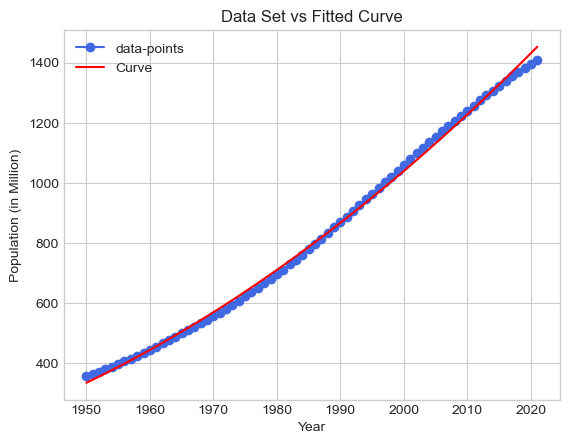

In [14]:
plt.title("Data Set vs Fitted Curve")
plt.xlabel("Year")
plt.ylabel("Population (in Million)")

plt.plot(year, population, "-o", label="data-points", color="royalblue")
plt.plot(year, curve_func(year, population, 3), "-", label="Curve", color="red")
plt.legend()
plt.show()

In [15]:
given_population = 400*random.randint(1, 4) + 50*random.randint(1, 5)
print(given_population)

if given_population < population[len(population)//4]:
    start, end = 0, len(population)//4
elif given_population > population[len(population)//4] and given_population < population[len(population)//2]:
    start, end = len(population)//4, len(population)//2
elif given_population > population[len(population)//2] and given_population < population[len(population)*3//4]:
    start, end = len(population)//2, len(population)*3//4
else: 
    start, end = len(population)*3//4, len(population)
    
year = year[start:end]
population = population[start:end]

constants = interpol_func(year, population)

850


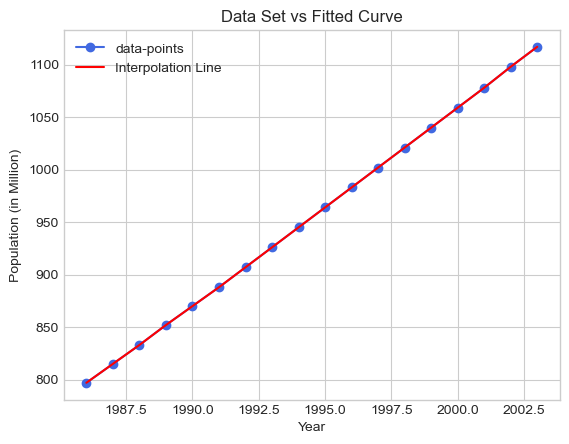

In [16]:
plt.title("Data Set vs Fitted Curve")
plt.xlabel("Year")
plt.ylabel("Population (in Million)")

plt.plot(year, population, "-o", label="data-points", color="royalblue")
plt.plot(year, [execute(i, constants) for i in range(1, len(year)+1)], label="Interpolation Line", color="red")
plt.legend()
plt.show()

In [17]:
x_init = newton_raphson(constants, given_population, len(population))

for i in range(10):
    x = newton_raphson(constants, 0, len(population))
    if x != None:
        result = execute(x, constants)
        if result < execute(x_init, constants):
            x_init = x
            
print(x_init+year[0], x_init, year[0])

1989.8971519939093 3.897151993909246 1986


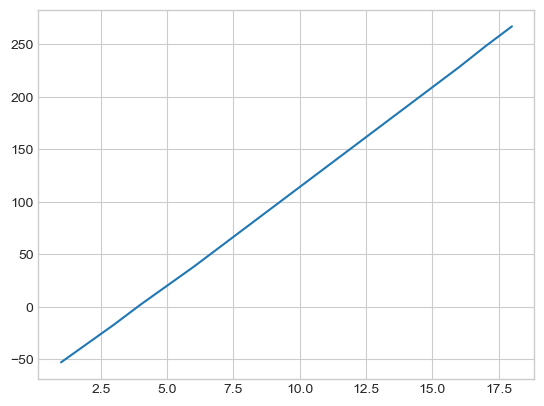

In [18]:
plt.plot([i-year[0]+1 for i in year], [execute(i-year[0]+1, constants) for i in year])
plt.show()